In [2]:
!pip install jovian --upgrade --quiet

# Idetifying FLower Species using Deep Learning and PyTorch 

TODO- Explanation introduction
1. Pick a dataset
2. Download the dataset
3. Import the dataset using Pytorch
4. Explore the dataset
5. Prepare the dataset for training
6. Move the dataset to the GPU
7. Define a neural network
8. Train the model
9. Make predictions on sample images
Iterate on it with different networks and hyperparameters.

### Download the Dataset

Using `opendatasets` and download the dataset from https://www.kaggle.com/alxmamaev/flowers-recognition

In [3]:
pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

In [5]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

Cleaning up directory

In [6]:
import os
import shutil

if os.path.exists('./flowers-recognition'):
  shutil.rmtree('./flowers-recognition')

In [7]:
od.download(dataset_url)

  6%|▌         | 25.0M/450M [00:00<00:01, 260MB/s]

100%|██████████| 450M/450M [00:01<00:00, 237MB/s]


In [8]:
data_dir = './flowers-recognition/flowers'

In [9]:
import os 

In [10]:
os.listdir(data_dir)

['flowers', 'dandelion', 'rose', 'daisy', 'sunflower', 'tulip']

# If any duplicate data or folder is created then we need to delete ?

In [11]:
import shutil
shutil.rmtree(data_dir + '/flowers')

In [12]:
os.listdir(data_dir)

['dandelion', 'rose', 'daisy', 'sunflower', 'tulip']

### Import the Dataset Into PyTorch

Use the "ImageFolder class from torchvision

In [13]:
from torchvision.datasets import ImageFolder

In [14]:
dataset = ImageFolder(data_dir)

In [15]:
len(dataset)

4323

In [16]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F971712B470>, 0)

In [17]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

## No of images in each class

In [18]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

dandelion : 1055
rose : 784
daisy : 769
sunflower : 734
tulip : 984


In [19]:
!pip install jovian --quite


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --quite


In [20]:
import jovian
jovian.commit(project='deep-learning-project-live')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/itsmohsin/deep-learning-project-live


'https://jovian.ai/itsmohsin/deep-learning-project-live'

### To Look inside the Dataset

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

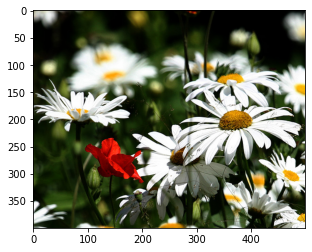

In [22]:
img, label = dataset[5]
plt.imshow(img)

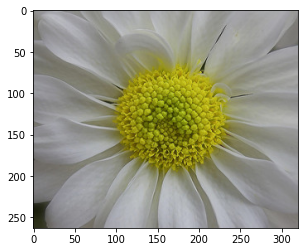

In [23]:
img, label = dataset[0]
plt.imshow(img)

### Need to Resize the Images

In [24]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

##As torch vision creates image into channel as first diminsion we need to put at third diminsion

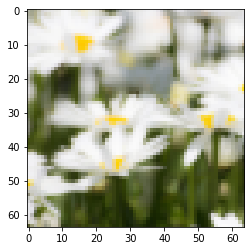

In [25]:
img, label = dataset[100]
plt.imshow(img.permute((1, 2, 0)))

### To select train size and validation size

In [26]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3891, 432)

## To Randomly select images

In [27]:
from torch.utils.data import random_split
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3891, 432)

In [28]:
from torch.utils.data import DataLoader

batch_size = 128

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

In [29]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

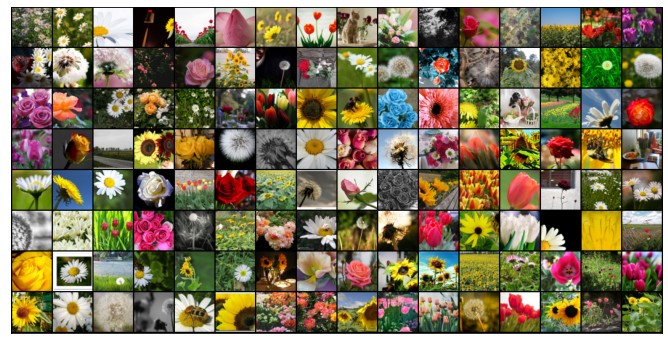

In [30]:
show_batch(train_dl)

### Utility Functions and Classes

In [31]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### To Check if gpu is enable 

In [32]:
torch.cuda.is_available()

True

In [33]:
device = get_default_device()
device

device(type='cuda')

In [34]:
img, label = dataset[0]

In [35]:
img.device

device(type='cpu')

In [36]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [37]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### Model and Training Utilties

In [38]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
      # "Calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
      # "Calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [39]:
@torch.no_grad()
def evaluate(model, val_loader):
  # """Evaluates the model's performance on the validation set"""

    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

###Model

In [40]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #  Input: 128 x 3 x 64 x 64 
        self.conv1 = conv_block(in_channels, 64) # Output: 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # Output: 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128),  # Output: 128 x 128 x 32 x 32
                                  conv_block(128, 128))  # Output: 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # Output: 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True)# Output: 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # Output: 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # Output: 128 x 512 x 8 x 8
        
        # self.classifier = nn.Sequential(nn.MaxPool2d(4), # Output: 128 x 512 x 2 x 2
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # Output: 128 x 512 x 1 x 1
                                        nn.Flatten(), # Output: 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [41]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [42]:
model.conv1[0].weight.device

device(type='cuda', index=0)

### Pass one batch of input tensor through the model

In [43]:
torch.cuda.empty_cache()
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('image.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  # print(preds)
  break

images.shape torch.Size([128, 3, 64, 64])
image.device cuda:0
preds.shape torch.Size([128, 5])


### Training the Model

In [44]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.15092329680919647, 'val_loss': 1.61289381980896}]

In [45]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.5363, val_loss: 1.6297, val_acc: 0.3205
Epoch [1], train_loss: 0.9870, val_loss: 0.9618, val_acc: 0.6369
Epoch [2], train_loss: 0.8546, val_loss: 0.8498, val_acc: 0.6630
Epoch [3], train_loss: 0.7865, val_loss: 0.9320, val_acc: 0.6610
Epoch [4], train_loss: 0.7088, val_loss: 0.9103, val_acc: 0.6660


In [46]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.8184, val_loss: 1.0360, val_acc: 0.6369
Epoch [1], train_loss: 0.6604, val_loss: 0.8995, val_acc: 0.6790
Epoch [2], train_loss: 0.6100, val_loss: 0.8969, val_acc: 0.7127
Epoch [3], train_loss: 0.5844, val_loss: 0.8131, val_acc: 0.6994
Epoch [4], train_loss: 0.5253, val_loss: 0.8356, val_acc: 0.7085


In [47]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.4333, val_loss: 0.6409, val_acc: 0.7761
Epoch [1], train_loss: 0.4168, val_loss: 0.6095, val_acc: 0.7864
Epoch [2], train_loss: 0.4151, val_loss: 0.6001, val_acc: 0.7857
Epoch [3], train_loss: 0.3947, val_loss: 0.5831, val_acc: 0.7846
Epoch [4], train_loss: 0.3986, val_loss: 0.5782, val_acc: 0.7992


In [48]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.SGD)

Epoch [0], train_loss: 0.3922, val_loss: 0.5977, val_acc: 0.7905
Epoch [1], train_loss: 0.3902, val_loss: 0.5746, val_acc: 0.7953
Epoch [2], train_loss: 0.4007, val_loss: 0.5834, val_acc: 0.7848
Epoch [3], train_loss: 0.3960, val_loss: 0.5811, val_acc: 0.7933
Epoch [4], train_loss: 0.3990, val_loss: 0.5843, val_acc: 0.7955


In [49]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

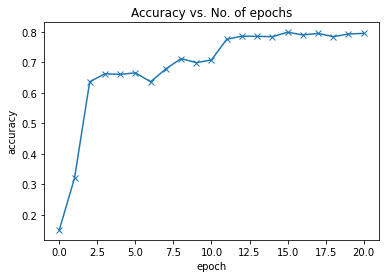

In [50]:
plot_accuracies(history)

In [51]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

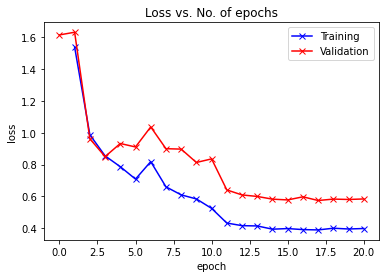

In [52]:
plot_losses(history)

### Record the Results

In [53]:
jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=128,
                       arch= 'ResNet9',
                       epochs='20',
                       lrs=[0.001, 0.001, 1e-4, 1e-4],
                       opt=['Adam', 'Adam', 'Adam', 'SGD'])
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_acc=history[-1]['val_acc'],
                   val_loss=history[-1]['val_loss'])

[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [54]:
jovian.commit(project='deep-learning-project-live')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/itsmohsin/deep-learning-project-live


'https://jovian.ai/itsmohsin/deep-learning-project-live'

### Test with Individual Images

In [55]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [56]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction', pred)

Target: sunflower
Prediction sunflower


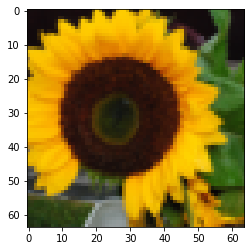

In [57]:
show_image_prediction(*valid_ds[100])

Target: tulip
Prediction tulip


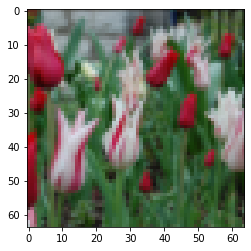

In [58]:
show_image_prediction(*valid_ds[123])

Target: daisy
Prediction daisy


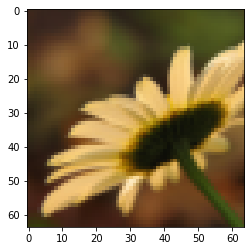

In [59]:
show_image_prediction(*valid_ds[303])

Target: tulip
Prediction rose


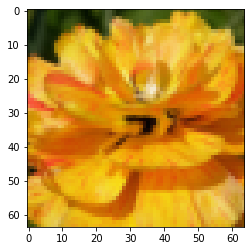

In [60]:
show_image_prediction(*valid_ds[225])

Target: sunflower
Prediction sunflower


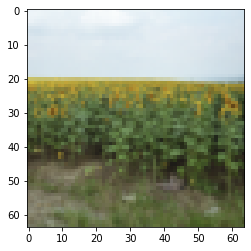

In [61]:
show_image_prediction(*valid_ds[40])

###Saving the Model and Commit

In [62]:
torch.save(model.state_dict(), 'flower-resnet9.pth')

In [63]:
jovian.commit(project='deep-learning-project-live', outputs=['flower-resnet9.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/itsmohsin/deep-learning-project-live


'https://jovian.ai/itsmohsin/deep-learning-project-live'

## Transfer Learning

In [64]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [65]:
model = to_device(ResNet34(len(dataset.classes), pretrained=True), device)

In [66]:
model

ResNet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [67]:
import torchvision.transforms as tt

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(img_size),
                                            tt.RandomCrop(img_size),
                                            tt.ToTensor(), tt.Normalize(*imagenet_stats)]))

In [68]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

batch_size = 64

# PyTorch data loaders
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                      batch_size*2,
                      num_workers=4,
                      pin_memory=True)

In [69]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [70]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [71]:
model = to_device(ResNet34(len(dataset.classes), pretrained=True), device)

In [72]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.205078125, 'val_loss': 1.693619966506958}]

In [73]:
history += fit_one_cycle(10, 0.001, model , train_dl,
              valid_dl, weight_decay=0.01,
              grad_clip=0.1, opt_func=torch.optim.Adam)


Epoch [0], train_loss: 0.4942, val_loss: 0.3843, val_acc: 0.8509



Epoch [1], train_loss: 0.4317, val_loss: 7.4756, val_acc: 0.4408



Epoch [2], train_loss: 0.6339, val_loss: 0.8697, val_acc: 0.6940



Epoch [3], train_loss: 0.6233, val_loss: 1.0092, val_acc: 0.6185



Epoch [4], train_loss: 0.5628, val_loss: 0.8226, val_acc: 0.6986



Epoch [5], train_loss: 0.5376, val_loss: 0.6092, val_acc: 0.7793



Epoch [6], train_loss: 0.4613, val_loss: 0.5750, val_acc: 0.7897



Epoch [7], train_loss: 0.3745, val_loss: 0.4108, val_acc: 0.8444



Epoch [8], train_loss: 0.2507, val_loss: 0.2786, val_acc: 0.8978



Epoch [9], train_loss: 0.1827, val_loss: 0.2835, val_acc: 0.8926


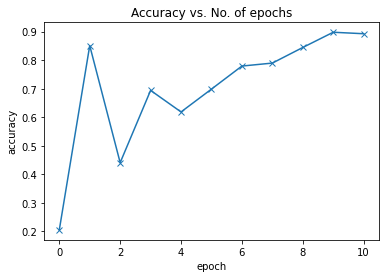

In [74]:
plot_accuracies(history)

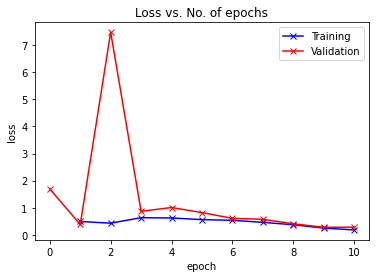

In [75]:
plot_losses(history)

In [76]:
import numpy as np
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

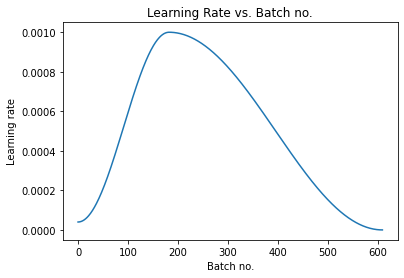

In [77]:
plot_lrs(history)

In [78]:
jovian.reset()
jovian.log_dataset(image_size=224)
jovian.log_hyperparams(batch_size=64,
                       arch= 'ResNet34',
                       epochs='10',
                       lrs=[0.001],
                       opt=['Adam'])
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_acc=history[-1]['val_acc'],
                   val_loss=history[-1]['val_loss'])

[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [79]:
torch.save(model.state_dict(), 'flower-resnet34.pth')

In [80]:
jovian.commit(project='deep-learning-project-live', outputs=['flower-resnet34.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/itsmohsin/deep-learning-project-live


'https://jovian.ai/itsmohsin/deep-learning-project-live'

In [81]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: sunflower (3)
Predicted sunflower


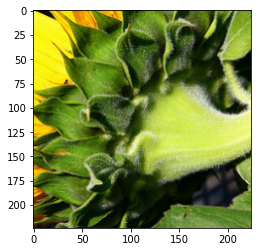

In [83]:
img, label = valid_ds[0]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted', pred)

Label: rose (2)
Predicted rose


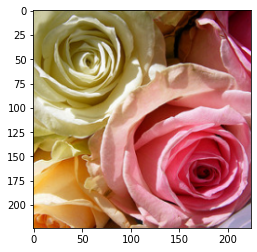

In [88]:
img, label = valid_ds[25]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted', pred)

Label: dandelion (1)
Predicted dandelion


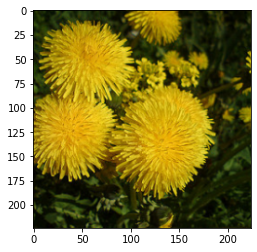

In [89]:
img, label = valid_ds[24]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted', pred)

Label: tulip (4)
Predicted tulip


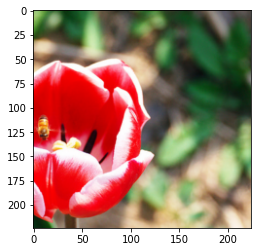

In [90]:
img, label = valid_ds[49]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted', pred)

Label: rose (2)
Predicted rose


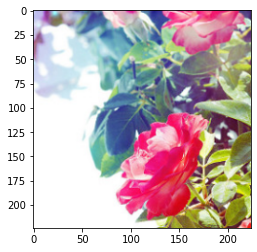

In [91]:
img, label = valid_ds[99]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted', pred)

In [ ]:
jovian.commit(project='')